# Clustering

This notebook uses the **topic modelling** output from the previous notebook along with a number of original and newly created features to conduct unsupervised **clustering** on the unique tweets dataset identified as belong to the "Political" topic. 

The goal of this clustering is to see if it is possible to uncover specifically the **misinformation** tweets.

To do this, we will cluster the "Political" tweets using the following features:
1. Lemmatized tweet content
2. Assigned Topic Label (from GSDMM Model)
3. Dialect
4. Sentiment
5. Whether the unique tweet is original or a retweet 
6. Number of times this tweet occurred in the dataset
7. User in dataset who first tweeted this tweet **(!!)**
8. First-Tweet User characteristics:
    - The number of tweets with exact same timestamp this user tweeted.
    - The number of followers this user has.
    - The number of users this user follows.
    - Total number of tweets by this user.
    - Ratio of following vs. followers.

**(!!)** Note that this may not in fact be the user who wrote the **original tweet** as some of the tweets in the dataset are only retweet versions and do not include the original tweet. I.e. the original tweet was not tweeted by a user Twitter identified as malicious. This is why we also include the feature 'Is_Retweet'.

A number of these features (listed below) will have to be created. That's why this notebook will first dive into a Feature Engineering section, after which we will conduct the Clustering.

The output of the Clustering will - hopefully - be the identification of misinformation tweets vs. non-misinformation tweets, i.e. a binary label (True / False). This output will be used to construct a **classification model** in the following notebook.


## Notebook Outline

1. Importing Libraries


2. Importing Datasets
    - Only unique tweets assigned one of the Political Topics by best GSDMM model


3. Feature Engineering
    - Create 'Dialect' Feature
    - Create 'Sentiment' Feature
    - Get 'First_User' Feature
    - Get 'Is_Original' Feature
    - Get 'Date_First' Feature
    - Create 'N_Appearances' Feature
    - Create User Characteristics Features


4. Clustering


5. Conclusions

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# distributed processing libraries
import coiled
import dask
from dask import distributed
from dask.distributed import Client, progress
import dask.dataframe as dd
import dask.array as da

# machine learning libraries
import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import joblib
from dask_ml.decomposition import PCA
from dask_ml.cluster import KMeans, SpectralClustering
from dask_ml.preprocessing import StandardScaler


# NLP libraries
import gensim
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc
from camel_tools.dialectid import DialectIdentifier
from camel_tools.sentiment import SentimentAnalyzer

In [2]:
print('pandas version: %s' % pd.__version__)
print('numpy version: %s' % np.__version__)
print('coiled version: %s' % coiled.__version__)
print('dask version: %s' % dask.__version__)
print('sklearn version: %s' % sklearn.__version__)

pandas version: 1.2.4
numpy version: 1.19.2
coiled version: 0.0.39.1
dask version: 2021.05.0
sklearn version: 0.24.1


# 2. Setting up AWS Cluster

In [3]:
%%time
# create coiled cluster
cluster = coiled.Cluster(
    name='cap3-clustering',
    shutdown_on_close=False,
    configuration="cap3-clustering-s2_8-w4_16",
    n_workers=25,
    scheduler_options={"idle_timeout": "2 hours"}
)

Output()

Found software environment build


CPU times: user 29.1 s, sys: 7.63 s, total: 36.8 s
Wall time: 4min 6s


In [4]:
# connect cluster to Dask
client = Client(cluster)
print('Dashboard:', client.dashboard_link)

Dashboard: http://ec2-3-142-246-14.us-east-2.compute.amazonaws.com:8787


# 3. Importing Datasets

Let's import the subset of Political Tweets that we created in the previous notebook. As a reminder, we created this subset by filtering the 6M+ unique tweets through an LDA and then a GSDMM model.

In [4]:
%%time
df_pol = pd.read_parquet('/Users/richard/Desktop/data_cap3/processed/df_political_for_clustering.parquet',
                     engine='pyarrow')

CPU times: user 1.29 s, sys: 289 ms, total: 1.58 s
Wall time: 1.82 s


We will also need the full dataset of all 36M tweets as well as the set of unique users.

In [5]:
# import full dataset with tweet_texts as indices from S3 bucket
ddf_full = dd.read_parquet(
                           's3://twitter-saudi-us-east-2/interim/ddf_complete_with_tweets_as_indices.parquet',
                           engine='pyarrow',
                           blocksize="64MiB"
).persist()

In [6]:
# import dataset of unique users
df_users = pd.read_parquet('s3://twitter-saudi-us-east-2/processed/df_unique_users.parquet',
                           engine='pyarrow')

# 4. Feature Engineering

In this section we will engineer the extra features we will use to further categorize our Political Content tweets.

The set of unique tweets already includes the features:
- User_reference_id of first user who tweeted this unique tweet
- The timestamp of the first appearance of this unique tweet
- Whether the first appearance of this unique tweet was a retweet or not

We will just change the column names of these and then proceed to:

- Create 'Dialect' Feature
- Create 'Sentiment' Feature
- Create 'N_Appearances' Feature
- Create User Characteristics Features:
    - The number of tweets with exact same timestamp this user tweeted.
    - The number of followers this user has.
    - The number of users this user follows.
    - Total number of tweets by this user.
    - Ratio of following vs. followers.


## 3.1. Rename Existing Features

In [3]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
3              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
4              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
6             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
3                                            None        True   
4                                            None       False   
6              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  user_reference_id     timestamp_first  gsdmm_topic  
0     9.999468e+17                  0 2018-05-25 13:07:00           11  
1              NaN                  5 2018-05-25 13:08:00           12  
3     9.995083e+17                 58 2018-05-25 00:27:00           18  
4              NaN                  1 2018-05-25 13:10:00           12  
6     1.000005e+18                 22 2018-05-25 13:30:00           11

In [4]:
df_pol.rename(columns={
    'user_reference_id': 'first_user',
    'timestamp_first': 'first_timestamp'
}, inplace=True)

In [5]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
3              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
4              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
6             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
3                                            None        True   
4                                            None       False   
6              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic  
0     9.999468e+17           0 2018-05-25 13:07:00           11  
1              NaN           5 2018-05-25 13:08:00           12  
3     9.995083e+17          58 2018-05-25 00:27:00           18  
4              NaN           1 2018-05-25 13:10:00           12  
6     1.000005e+18          22 2018-05-25 13:30:00           11

## 3.2. Create Dialect Feature

In this section, we will run the **Dialect Identifier** included in the **camel-tools** library to identify the most likely dialect the tweet is written in (out of 26 options: 25 city dialects and Modern Standard Arabic).

The table below displays the 26 dialects and their abbreviations.


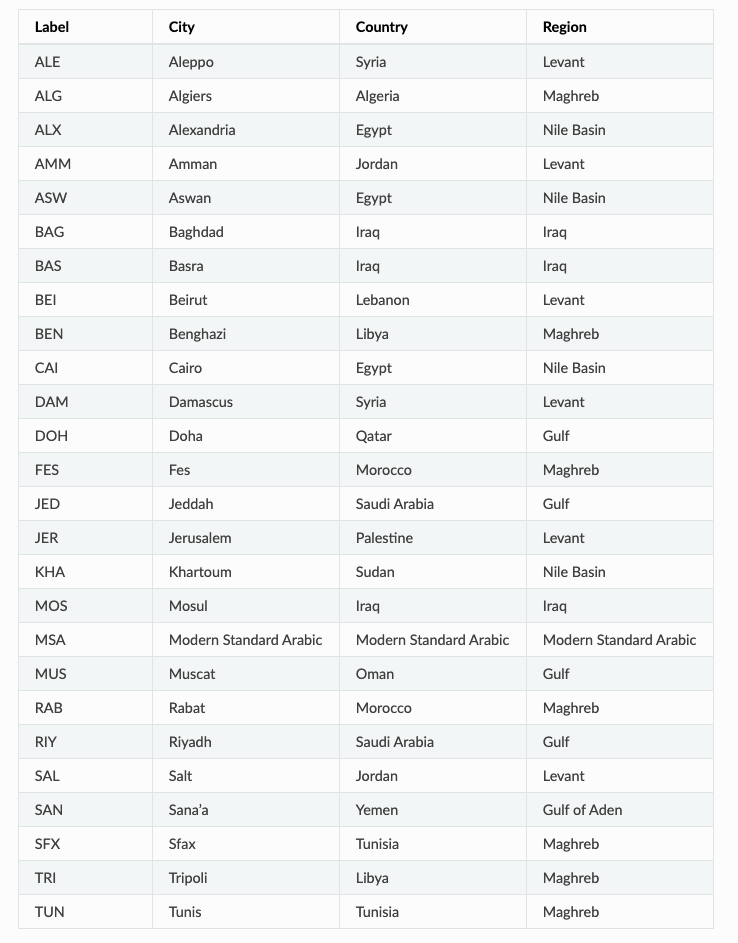

In [6]:
from IPython.display import Image
Image(filename='/Users/richard/Desktop/springboard_repo/capstones/three/figures/arabic-dialects-table.png')

Both the Dialect Identifier and Sentiment Analysis native to **camel-tools** require the input to be a sentence, i.e. a single string per document. This means we should use the original sentences (after data cleaning but before tokenization). We have this untokenized set already, saved as df_unique_tweets_hashtags_reset_index in our S3 bucket.

**NOTE:** These tweets have not undergone two Arabic-specific preprocessing steps: orthographic normalization and dediacritization. Let's see how the Dialect Identifier and Sentiment Analyser run first; we may have to conduct those two preprocessing steps again here to get the best performance.

In [7]:
%%time
# import the cleaned dataset of full-text tweets
df_unique_fulltext = pd.read_parquet('s3://twitter-saudi-us-east-2/interim/df_unique_tweets_hashtags_reset_index.parquet',
                              engine='pyarrow')

CPU times: user 46 s, sys: 27.5 s, total: 1min 13s
Wall time: 3min 32s


Next step is to subset these full-text tweets to include only the Political Tweets, using their unique index.

In [8]:
# use unique id column to index into df_unique
df_pol_fulltext = df_unique_fulltext.loc[df_pol.unique_tweetid]

In [9]:
# verify that dataframes are of same length
df_pol_fulltext.shape[0] == df_pol.shape[0]

True

In [10]:
# instantiate the Dialect Identifier
did = DialectIdentifier.pretrained()

/Users/richard/miniconda3/envs/cap3-clustering/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/richard/miniconda3/envs/cap3-clustering/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/richard/miniconda3/envs/cap3-clustering/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/richard/miniconda3/envs/cap3-clustering/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpi

In [11]:
# get only full-text tweets
unique_fulltext = df_pol_fulltext.tweet_text

In [12]:
%%time
# convert into list to input into dialect identifier
unique_fulltext_list = list(unique_fulltext)

CPU times: user 74.6 ms, sys: 4.72 ms, total: 79.3 ms
Wall time: 85.4 ms


In [13]:
%%time
# get dialect predictions
dialect_pred = did.predict(unique_fulltext_list)

CPU times: user 7min 8s, sys: 36.4 s, total: 7min 45s
Wall time: 8min 8s


Each dialect prediction is a tuple containing the top prediction and the percentage score of each dialect. 

Below we extract only the top predictions.

In [14]:
# get top prediction
top_dialects = [p.top for p in dialect_pred]

Now let's add these to our dataframe of political tweets as column 'dialect_prediction'.

In [16]:
df_pol['dialect_pred'] = top_dialects

In [17]:
df_pol

unique_tweetid                                         tweet_text  \
0                   11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1                   16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
3                   29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
4                   36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
6                  142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   
...                ...                                                ...   
349565         3781812  [غُوطَة_1, شَرْقِيّ_1, دَيْر_2, عُصْفُور_1, طَ...   
349566         3781813  [رِيف_1, دِمَشْق_1, دارِي_1, ٱِشْتِباك_1, ثائِ...   
349568         3781871                              [ال_1, ال_1, كُرَة_1]   
349569         3781942  [غَرَد_1, صُورَة_1, مُبادَرَة_1, مُؤَسِّس_1, أ...   
349570         3781953  [تابِع_1, رَوَى-i_1, خَلِيجِيّ_2, قَضِيَّة_1, ...   

                                              hashtags  is_retweet  \
0                                               [عاجل]        True   
1       [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
3                                                 None        True   
4                                                 None       False   
6                   [فضيحة القرن, احد الاندية العربية]        True   
...                                                ...         ...   
349565                  [الغوطة الشرقية, دير العصافير]       False   
349566               [ريف دمشق, داريا, الغوطة الغربية]       False   
349568                                            None        True   
349569           [غرد بصورة, مؤسسة الأمير محمد بن فهد]        True   
349570                                 [روتانا خليجية]       False   

        retweet_tweetid  first_user     first_timestamp  gsdmm_topic  \
0          9.999468e+17           0 2018-05-25 13:07:00           11   
1                   NaN           5 2018-05-25 13:08:00           12   
3          9.995083e+17          58 2018-05-25 00:27:00           18   
4                   NaN           1 2018-05-25 13:10:00           12   
6          1.000005e+18          22 2018-05-25 13:30:00           11   
...                 ...         ...                 ...          ...   
349565              NaN         149 2015-06-23 14:20:00            4   
349566              NaN         149 2015-06-23 14:22:00            4   
349568     6.080279e+17        3606 2015-06-23 14:27:00           18   
349569     6.098624e+17        3036 2015-06-23 14:44:00           18   
349570              NaN          34 2015-06-23 14:46:00           12   

       dialect_pred  
0               MUS  
1               ALG  
3               SAN  
4               MSA  
6               KHA  
...             ...  
349565          BEN  
349566          ALG  
349568          TUN  
349569          BEI  
349570          RIY  

[284386 rows x 9 columns]

Great, that works. Let's proceed to add the Sentiment Feature as well.

**THOUGHT:** Now that I have dialects, we have some sort of sense of geographical location. If we turn each dialect tag into a Lat/Long point then we could create a map with all 25 cities, with the circle size increasing depending on the number of tweets that have that dialect. Not exact science, but would make for interesting visual.

## 3.3. Create Sentiment Feature

In [18]:
# instantiate the analyser
sa = SentimentAnalyzer.pretrained()

In [19]:
%%time
# predict sentiment of all political tweets
sentiments = sa.predict(unique_fulltext_list)

CPU times: user 8h 52min 54s, sys: 11min 19s, total: 9h 4min 14s
Wall time: 9h 3min 13s


We can now add these to our dataframe of political tweets as well, as column 'sentiment_pred'.

In [21]:
df_pol['sentiment_pred'] = sentiments

In [22]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
3              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
4              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
6             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
3                                            None        True   
4                                            None       False   
6              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0     9.999468e+17           0 2018-05-25 13:07:00           11          MUS   
1              NaN           5 2018-05-25 13:08:00           12          ALG   
3     9.995083e+17          58 2018-05-25 00:27:00           18          SAN   
4              NaN           1 2018-05-25 13:10:00           12          MSA   
6     1.000005e+18          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  
0       negative  
1        neutral  
3        neutral  
4       negative  
6       negative

In [23]:
df_pol.to_parquet('/Users/richard/Desktop/data_cap3/interim/df_political_for_clustering_with_dialect_and_sentiment.parquet',
                     engine='pyarrow')

Great!

Let's move on to engineering the next feature.

## 3.4. Create Number of Appearances Feature

In this section we add a feature **n_appearances** which counts the number of times the unique tweet appears in the full dataset of 36M tweets.

In [28]:
%%time
df_unique_counts = ddf_full.groupby('unique_tweetid').user_reference_id.count().compute()

CPU times: user 5.52 s, sys: 1.51 s, total: 7.03 s
Wall time: 48 s


In [29]:
df_unique_counts = pd.DataFrame(df_unique_counts)

In [30]:
df_unique_counts.rename(columns={'user_reference_id': 'appearance_count'}, inplace=True)

In [35]:
df_unique_counts.head()

appearance_count
unique_tweetid                  
0.0                            3
1.0                           12
2.0                            3
3.0                            1
4.0                         4947

In [32]:
df_unique_counts['appearance_count'].min(), df_unique_counts['appearance_count'].max()

(1, 131855)

Alright, let's join these counts to the subset of our unique political tweets.

In [33]:
df_pol

unique_tweetid                                         tweet_text  \
0                   11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1                   16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
3                   29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
4                   36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
6                  142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   
...                ...                                                ...   
349565         3781812  [غُوطَة_1, شَرْقِيّ_1, دَيْر_2, عُصْفُور_1, طَ...   
349566         3781813  [رِيف_1, دِمَشْق_1, دارِي_1, ٱِشْتِباك_1, ثائِ...   
349568         3781871                              [ال_1, ال_1, كُرَة_1]   
349569         3781942  [غَرَد_1, صُورَة_1, مُبادَرَة_1, مُؤَسِّس_1, أ...   
349570         3781953  [تابِع_1, رَوَى-i_1, خَلِيجِيّ_2, قَضِيَّة_1, ...   

                                              hashtags  is_retweet  \
0                                               [عاجل]        True   
1       [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
3                                                 None        True   
4                                                 None       False   
6                   [فضيحة القرن, احد الاندية العربية]        True   
...                                                ...         ...   
349565                  [الغوطة الشرقية, دير العصافير]       False   
349566               [ريف دمشق, داريا, الغوطة الغربية]       False   
349568                                            None        True   
349569           [غرد بصورة, مؤسسة الأمير محمد بن فهد]        True   
349570                                 [روتانا خليجية]       False   

        retweet_tweetid  first_user     first_timestamp  gsdmm_topic  \
0          9.999468e+17           0 2018-05-25 13:07:00           11   
1                   NaN           5 2018-05-25 13:08:00           12   
3          9.995083e+17          58 2018-05-25 00:27:00           18   
4                   NaN           1 2018-05-25 13:10:00           12   
6          1.000005e+18          22 2018-05-25 13:30:00           11   
...                 ...         ...                 ...          ...   
349565              NaN         149 2015-06-23 14:20:00            4   
349566              NaN         149 2015-06-23 14:22:00            4   
349568     6.080279e+17        3606 2015-06-23 14:27:00           18   
349569     6.098624e+17        3036 2015-06-23 14:44:00           18   
349570              NaN          34 2015-06-23 14:46:00           12   

       dialect_pred sentiment_pred  
0               MUS       negative  
1               ALG        neutral  
3               SAN        neutral  
4               MSA       negative  
6               KHA       negative  
...             ...            ...  
349565          BEN       negative  
349566          ALG       negative  
349568          TUN        neutral  
349569          BEI       negative  
349570          RIY        neutral  

[284386 rows x 10 columns]

In [49]:
# reset index to turn unique_tweetid into column
df_unique_counts = df_unique_counts.reset_index(drop=False)

In [50]:
df_unique_counts.head()

unique_tweetid  appearance_count
0             0.0                 3
1             1.0                12
2             2.0                 3
3             3.0                 1
4             4.0              4947

In [54]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
3              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
4             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
2                                            None        True   
3                                            None       False   
4              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0     9.999468e+17           0 2018-05-25 13:07:00           11          MUS   
1              NaN           5 2018-05-25 13:08:00           12          ALG   
2     9.995083e+17          58 2018-05-25 00:27:00           18          SAN   
3              NaN           1 2018-05-25 13:10:00           12          MSA   
4     1.000005e+18          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  appearance_count  
0       negative                 3  
1        neutral                12  
2        neutral                 1  
3       negative              4947  
4       negative                38

In [56]:
# join
df_pol = df_pol.merge(df_unique_counts,
                                how='left',
                                on='unique_tweetid',
)

In [63]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
3              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
4             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
2                                            None        True   
3                                            None       False   
4              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0     9.999468e+17           0 2018-05-25 13:07:00           11          MUS   
1              NaN           5 2018-05-25 13:08:00           12          ALG   
2     9.995083e+17          58 2018-05-25 00:27:00           18          SAN   
3              NaN           1 2018-05-25 13:10:00           12          MSA   
4     1.000005e+18          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  appearance_count  
0       negative                 1  
1        neutral                 1  
2        neutral                 4  
3       negative                 1  
4       negative                 1

In [60]:
df_unique_counts.loc[36]

unique_tweetid      36.0
appearance_count     1.0
Name: 36, dtype: float64

Fantastic, this works.

## 3.5. Create User-Characteristics Features

In this section we will engineer a number of features that characterize the users who first tweeted each unique tweet.

We will include:
- The number of tweets with exact same timestamp this user tweeted.
- The number of followers this user has.
- The number of users this user follows.
- Total number of tweets by this user.
- Ratio of following vs. followers.

### 3.5.1. Total Number of Tweets

In [64]:
df_users.head()

user_screen_name  \
0                                        y_44a_   
1  iXwa1+qxYAH2hEJ9nDG11qo6nmcpl89IQKhDRDqpfU4=   
2   Gj+bihYSO0L5Ht1+f9OEqP42KbnJWtNK4qv0WJr0cs=   
3      2SJuOzyE6GQOsmW9ukY3ChH8rl049x6mDNZi3EM=   
4   ytmVN9opEFMM7Uk+0O0XgSuOpIRlok5Xqu+jel9qyM=   

                                         userid  follower_count  \
0                            948302862098092034          9007.0   
1  iXwa1+qxYAH2hEJ9nDG11qo6nmcpl89IQKhDRDqpfU4=           168.0   
2   Gj+bihYSO0L5Ht1+f9OEqP42KbnJWtNK4qv0WJr0cs=          1623.0   
3      2SJuOzyE6GQOsmW9ukY3ChH8rl049x6mDNZi3EM=          1850.0   
4   ytmVN9opEFMM7Uk+0O0XgSuOpIRlok5Xqu+jel9qyM=          3928.0   

   following_count  tweet_count  flagged  
0           8821.0     258339.0      1.0  
1            408.0       4982.0      1.0  
2           2022.0      59605.0      1.0  
3           1594.0      14833.0      1.0  
4           4273.0      17643.0      1.0

In [65]:
ddf_full.head()

unique_tweetid  user_reference_id  follower_count  \
twitter_tweetid                                                          
1000000000447930368             0.0                  0            9007   
1000000030391095297             1.0                  0            9007   
1000000039362662400             2.0                  0            9007   
1000000054911033344             3.0                  1             168   
1000000204865789954             4.0                  2            1623   

                     following_count  \
twitter_tweetid                        
1000000000447930368             8821   
1000000030391095297             8821   
1000000039362662400             8821   
1000000054911033344              408   
1000000204865789954             2022   

                                                              hashtags  \
twitter_tweetid                                                          
1000000000447930368                                               None   
1000000030391095297  [للتأجير, لبيع النطيطات, زحاليق مائيه صابونية,...   
1000000039362662400  [مظلات, آفاق الرياض, مظلات استراحات, مظلات مسا...   
1000000054911033344                                               None   
1000000204865789954                                               None   

                    tweet_language          tweet_time   tweet_client_name  \
twitter_tweetid                                                              
1000000000447930368             ar 2018-05-25 13:05:00  Twitter for iPhone   
1000000030391095297             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000039362662400             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000054911033344             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000204865789954             ar 2018-05-25 13:06:00           غرد بصدقة   

                     is_retweet  retweet_tweetid  retweet_user_reference_id  
twitter_tweetid                                                              
1000000000447930368        True     9.986493e+17                     4273.0  
1000000030391095297        True     9.996373e+17                     4274.0  
1000000039362662400        True     9.993939e+17                     4275.0  
1000000054911033344        True     9.983516e+17                     4276.0  
1000000204865789954       False     9.990000e+02                        NaN

In [66]:
df_users_count = pd.DataFrame(ddf_full.groupby('user_reference_id').unique_tweetid.count().compute())

In [67]:
df_users_count.head()

unique_tweetid
user_reference_id                
0                          257890
1                            4982
2                           59604
3                           14819
4                           17622

In [68]:
df_users_count.rename(columns={'unique_tweetid': 'user_tweet_count'}, inplace=True)

In [69]:
df_users_count.head()

user_tweet_count
user_reference_id                  
0                            257890
1                              4982
2                             59604
3                             14819
4                             17622

In [71]:
# reset index
df_users_count.reset_index(drop=False, inplace=True)

In [74]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
3              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
4             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
2                                            None        True   
3                                            None       False   
4              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0     9.999468e+17           0 2018-05-25 13:07:00           11          MUS   
1              NaN           5 2018-05-25 13:08:00           12          ALG   
2     9.995083e+17          58 2018-05-25 00:27:00           18          SAN   
3              NaN           1 2018-05-25 13:10:00           12          MSA   
4     1.000005e+18          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  appearance_count  
0       negative                 1  
1        neutral                 1  
2        neutral                 4  
3       negative                 1  
4       negative                 1

In [78]:
df_pol = df_pol.merge(df_users_count,
                      how='left',
                      left_on='first_user',
                      right_on='user_reference_id')

In [79]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
3              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
4             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
2                                            None        True   
3                                            None       False   
4              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0     9.999468e+17           0 2018-05-25 13:07:00           11          MUS   
1              NaN           5 2018-05-25 13:08:00           12          ALG   
2     9.995083e+17          58 2018-05-25 00:27:00           18          SAN   
3              NaN           1 2018-05-25 13:10:00           12          MSA   
4     1.000005e+18          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  appearance_count  user_reference_id  user_tweet_count  
0       negative                 1                  0            257890  
1        neutral                 1                  5              1698  
2        neutral                 4                 58             31135  
3       negative                 1                  1              4982  
4       negative                 1                 22             13403

In [81]:
df_users_count.loc[58]

user_reference_id       58
user_tweet_count     31135
Name: 58, dtype: int64

In [82]:
# drop user_reference_id
df_pol.drop(columns=['user_reference_id'], inplace=True)

Fantastic.

### 3.5.2. Number of Tweets with Identical Timestamps

In this section we create the feature **n_identical_timestamps** to count the number of tweets with identical timestamps (more than 1) a user has produced.

We include this feature as a possible indication that the user is a bot.

- get

In [83]:
ddf_full.head()

unique_tweetid  user_reference_id  follower_count  \
twitter_tweetid                                                          
1000000000447930368             0.0                  0            9007   
1000000030391095297             1.0                  0            9007   
1000000039362662400             2.0                  0            9007   
1000000054911033344             3.0                  1             168   
1000000204865789954             4.0                  2            1623   

                     following_count  \
twitter_tweetid                        
1000000000447930368             8821   
1000000030391095297             8821   
1000000039362662400             8821   
1000000054911033344              408   
1000000204865789954             2022   

                                                              hashtags  \
twitter_tweetid                                                          
1000000000447930368                                               None   
1000000030391095297  [للتأجير, لبيع النطيطات, زحاليق مائيه صابونية,...   
1000000039362662400  [مظلات, آفاق الرياض, مظلات استراحات, مظلات مسا...   
1000000054911033344                                               None   
1000000204865789954                                               None   

                    tweet_language          tweet_time   tweet_client_name  \
twitter_tweetid                                                              
1000000000447930368             ar 2018-05-25 13:05:00  Twitter for iPhone   
1000000030391095297             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000039362662400             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000054911033344             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000204865789954             ar 2018-05-25 13:06:00           غرد بصدقة   

                     is_retweet  retweet_tweetid  retweet_user_reference_id  
twitter_tweetid                                                              
1000000000447930368        True     9.986493e+17                     4273.0  
1000000030391095297        True     9.996373e+17                     4274.0  
1000000039362662400        True     9.993939e+17                     4275.0  
1000000054911033344        True     9.983516e+17                     4276.0  
1000000204865789954       False     9.990000e+02                        NaN

In [84]:
%%time
# get number of tweet_times per user using a groupby
df_timestamp = ddf_full.groupby(['user_reference_id', 'tweet_time']).unique_tweetid.count().compute()

CPU times: user 7.08 s, sys: 1.98 s, total: 9.06 s
Wall time: 2min 22s


In [85]:
# convert result to dataframe
df_timestamp = pd.DataFrame(df_timestamp)

In [86]:
# inspect
df_timestamp.head()

unique_tweetid
user_reference_id tweet_time                         
0                 2018-05-25 13:05:00               2
                  2018-05-25 13:06:00               6
                  2018-05-25 13:07:00               3
                  2018-05-25 13:08:00               5
                  2018-05-25 13:09:00               5

In [87]:
# rename column
df_timestamp.rename(columns={'unique_tweetid': 'unique_tweet_count'}, inplace=True)

In [88]:
df_timestamp.head()

unique_tweet_count
user_reference_id tweet_time                             
0                 2018-05-25 13:05:00                   2
                  2018-05-25 13:06:00                   6
                  2018-05-25 13:07:00                   3
                  2018-05-25 13:08:00                   5
                  2018-05-25 13:09:00                   5

In [89]:
df_timestamp.shape

(8615840, 1)

In [90]:
# drop any tweet_times for which count is 1
df_timestamp_multiple = df_timestamp[df_timestamp.unique_tweet_count > 1]

In [91]:
df_timestamp_multiple.shape

(5034538, 1)

In [92]:
# reset
df_timestamp_multiple.reset_index(level=[1], inplace=True)

In [93]:
# count number of tweet_times per user
df_timestamp_counts = pd.DataFrame(df_timestamp_multiple.groupby('user_reference_id').tweet_time.count())

In [94]:
df_timestamp_counts.head()

tweet_time
user_reference_id            
0                       35994
1                         110
2                        1145
3                         984
4                        2800

In [95]:
df_timestamp_counts.shape

(3115, 1)

In [96]:
df_timestamp_counts.rename(columns={'tweet_time': 'timestamp_counts'}, inplace=True)

In [101]:
# join to political tweets dataframe
df_pol = df_pol.merge(df_timestamp_counts,
                      how='left',
                      left_on='first_user',
                      right_index=True)

In [102]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
3              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
4             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
2                                            None        True   
3                                            None       False   
4              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0     9.999468e+17           0 2018-05-25 13:07:00           11          MUS   
1              NaN           5 2018-05-25 13:08:00           12          ALG   
2     9.995083e+17          58 2018-05-25 00:27:00           18          SAN   
3              NaN           1 2018-05-25 13:10:00           12          MSA   
4     1.000005e+18          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  appearance_count  user_tweet_count  timestamp_counts  
0       negative                 1            257890           35994.0  
1        neutral                 1              1698              17.0  
2        neutral                 4             31135            3744.0  
3       negative                 1              4982             110.0  
4       negative                 1             13403            1139.0

In [103]:
df_timestamp_counts.loc[22]

timestamp_counts    1139
Name: 22, dtype: int64

Excellent, that works.

Now just set all NaN entries in this new column to 0.

In [109]:
df_pol.loc[df_pol.timestamp_counts.isnull(), 'timestamp_counts'] = 0

In [110]:
df_pol.timestamp_counts.isnull().sum()

0

Excellent, we can proceed.

### 3.5.3. Number of Followers / Following

As a final step, let's add the last 3 user-centric features:
- follower count
- following count

We'll add these all in one go with a simple join.

In [111]:
df_users.head(2)

user_screen_name  \
0                                        y_44a_   
1  iXwa1+qxYAH2hEJ9nDG11qo6nmcpl89IQKhDRDqpfU4=   

                                         userid  follower_count  \
0                            948302862098092034          9007.0   
1  iXwa1+qxYAH2hEJ9nDG11qo6nmcpl89IQKhDRDqpfU4=           168.0   

   following_count  tweet_count  flagged  
0           8821.0     258339.0      1.0  
1            408.0       4982.0      1.0

In [ ]:
# RUN THE CELL BELOW HERE AGAIN WITHOUT 'FLAGGED'
# ALL UNIQUE TWEETS WERE FIRST TWEETED BY USERS WHO WERE FLAGGED
# SO ITS A MEANINGLESS FEATURE

In [114]:
df_pol = df_pol.merge(df_users[['follower_count', 'following_count', 'flagged']],
                      how='left',
                      left_on='first_user',
                      right_index=True)

In [115]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
3              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
4             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
2                                            None        True   
3                                            None       False   
4              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0     9.999468e+17           0 2018-05-25 13:07:00           11          MUS   
1              NaN           5 2018-05-25 13:08:00           12          ALG   
2     9.995083e+17          58 2018-05-25 00:27:00           18          SAN   
3              NaN           1 2018-05-25 13:10:00           12          MSA   
4     1.000005e+18          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  appearance_count  user_tweet_count  timestamp_counts  \
0       negative                 1            257890           35994.0   
1        neutral                 1              1698              17.0   
2        neutral                 4             31135            3744.0   
3       negative                 1              4982             110.0   
4       negative                 1             13403            1139.0   

   follower_count  following_count  flagged  
0          9007.0           8821.0      1.0  
1           616.0           1668.0      1.0  
2          2370.0           3492.0      1.0  
3           168.0            408.0      1.0  
4          1257.0            539.0      1.0

Excellent.

All done here, let's save and then we're ready to set up our clustering.

## 3.6. Save

In [116]:
# save dataframe with new features to parquet
df_pol.to_parquet('/Users/richard/Desktop/data_cap3/interim/df_political_for_clustering_with_final_features.parquet',
                     engine='pyarrow')

# 4. Clustering

The goal of this section is to execute **2 unsupervised clustering approaches** in order to evaluate whether it's possible to sort out specifically the **misinformation** from the general batch of political-content tweets.

We will use 2 clustering approaches, selected based on the **scikit-learn documentation** overview included below:
- Agglomerative Clustering, because
    - it provides a helpful visual overview of the process of clustering and may thus tell us something meaningful about how these political tweets are subdivided
    - it is suitable for use with large sample size
- K-Means Clustering, because
    - it is a good general-purpose baseline model
    - suitable for large n_samples
    - we will follow the sklearn documentation advise, however, and **first run a Principal Components Analysis** to reduce the dimensionality of the data.

There is also research on specifically Short-Text Clustering (STC), for example [see here](https://www.aclweb.org/anthology/W19-4322.pdf). Deep Embedded Clustering, for example, 'learns a mapping from the data space to a lower-dimensional feature space while iteratively optimizing a clustering objective'. This is worth exploring at a later stage.

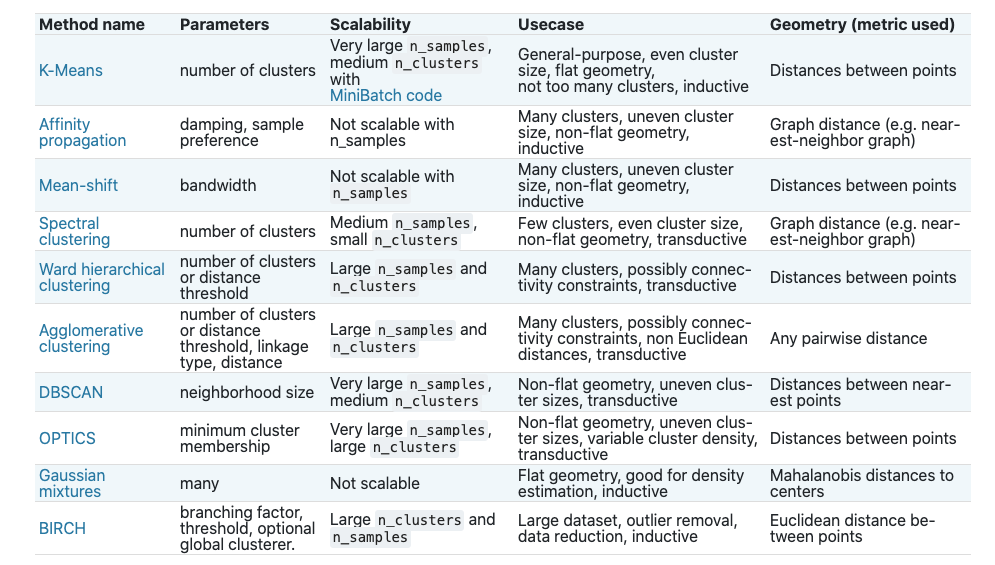

In [9]:
Image(filename='/Users/richard/Desktop/springboard_repo/capstones/three/figures/sklearn-clustering-overview.png')

Before we can begin building these models, we will have to pre-process our final data to:
- include no NaN values
- only numerical columns

We will use the following features to cluster our political tweetS:
- lemmatized tweet text
- is_retweet (categorical)
- GSDMM topic label
- dialect (categorical)
- sentiment (categorical)
- n_appearances
- user_n_followers
- user_n_following
- user_n_duplicate_timestamps
- user_n_tweets

We will have to:
1. Create word vectors
2. Drop unused features
3. One-hot encode categorical columns

## 4.1. Pre-Processing

### 4.1.1. Create Word Vectors (Tf-Idf)

Because we want to add additional features to our rows (tweets), we will use **Tf-Idf Vectorization** to turn our tweet texts into vectors. While **Word2Vec** is more popular - for good reason - it turns each word into a vector, rather than each tweet, and so makes it impossible for us to maintain tweets as our unit of observation.

In [118]:
# create array of documents
docs_pol = df_pol.tweet_text.to_numpy()

In [119]:
%%time
# create BOW dictionary
dictionary_pol = gensim.corpora.Dictionary(docs_pol)

CPU times: user 6.74 s, sys: 58.4 ms, total: 6.8 s
Wall time: 6.9 s


In [120]:
# filter extreme cases 
dictionary_pol.filter_extremes(no_below=15, no_above=0.8, keep_n=50000)

In [124]:
%%time
# map docs to bag of words
bow_corpus_pol = [dictionary_pol.doc2bow(doc) for doc in docs_pol]

CPU times: user 4.7 s, sys: 2.04 s, total: 6.74 s
Wall time: 7.08 s


In [125]:
%%time
# get tf-idf vectors
tfidf = TfidfModel(bow_corpus_pol)

CPU times: user 902 ms, sys: 51.1 ms, total: 953 ms
Wall time: 1.08 s


In [126]:
corpus_tfidf = tfidf[bow_corpus_pol]

Now let's turn this TFIDF model into features that we can feed into our Clustering algorithms.

In [127]:
# get number of docs and terms
num_docs = dictionary_pol.num_docs
num_terms = len(dictionary_pol.keys())

In [128]:
num_docs, num_terms

(284386, 10885)

In [72]:
%%time
# get documents as dense vector
corpus_tfidf_dense = corpus2dense(corpus_tfidf, num_terms, num_docs)

CPU times: user 2min 24s, sys: 26.6 s, total: 2min 50s
Wall time: 3min 6s


In [73]:
corpus_tfidf_dense.shape

(10885, 284386)

In [74]:
X_tweets_tfidf = corpus_tfidf_dense.T

In [75]:
X_tweets_tfidf.shape

(284386, 10885)

In [76]:
df_tweets_tfidf = pd.DataFrame(X_tweets_tfidf)

In [78]:
df_tweets_tfidf.head()

0        1        2         3         4         5         6      \
0  0.305829  0.23567  0.25127  0.260224  0.275877  0.241727  0.187905   
1  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000  0.000000   

      7         8         9      ...  10875  10876  10877  10878  10879  \
0  0.254542  0.184232  0.210081  ...    0.0    0.0    0.0    0.0    0.0   
1  0.000000  0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0   
2  0.000000  0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0   
3  0.000000  0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0   
4  0.000000  0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0   

   10880  10881  10882  10883  10884  
0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0  

[5 rows x 10885 columns]

OK. We have a matrix with 285K rows (our tweets) and 10885 columns (our words) and the tf-idf score of each word.

We can now proceed to pre-process the remaining features.

In [87]:
df_tweets_tfidf.columns = df_tweets_tfidf.columns.astype(str)

In [89]:
# save to parquet
df_tweets_tfidf.to_parquet('/Users/richard/Desktop/data_cap3/processed/df_political_as_tfidf_vectors.parquet',
                           engine='pyarrow')

### 4.1.2. Drop Unused Features

Let's drop the features we won't be using and then concatenate the remainder with the tf-idf vectors we created above.

In [3]:
df_tweets_tfidf.shape

(284386, 10885)

In [5]:
df_pol.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
3              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
4             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

                                         hashtags  is_retweet  \
0                                          [عاجل]        True   
1  [الحوثي, التحالف العربي, اليمن, الحاضر العربي]       False   
2                                            None        True   
3                                            None       False   
4              [فضيحة القرن, احد الاندية العربية]        True   

   retweet_tweetid  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0     9.999468e+17           0 2018-05-25 13:07:00           11          MUS   
1              NaN           5 2018-05-25 13:08:00           12          ALG   
2     9.995083e+17          58 2018-05-25 00:27:00           18          SAN   
3              NaN           1 2018-05-25 13:10:00           12          MSA   
4     1.000005e+18          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  appearance_count  user_tweet_count  timestamp_counts  \
0       negative                 1            257890           35994.0   
1        neutral                 1              1698              17.0   
2        neutral                 4             31135            3744.0   
3       negative                 1              4982             110.0   
4       negative                 1             13403            1139.0   

   follower_count  following_count  flagged  
0          9007.0           8821.0      1.0  
1           616.0           1668.0      1.0  
2          2370.0           3492.0      1.0  
3           168.0            408.0      1.0  
4          1257.0            539.0      1.0

In [6]:
# verify dataframe are of some length
df_tweets_tfidf.shape[0] == df_pol.shape[0]

True

In [7]:
# drop unused features
df_pol_cluster = df_pol.drop(columns=['hashtags', 'retweet_tweetid'])

In [8]:
df_pol_cluster.head(3)

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   

   is_retweet  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0        True           0 2018-05-25 13:07:00           11          MUS   
1       False           5 2018-05-25 13:08:00           12          ALG   
2        True          58 2018-05-25 00:27:00           18          SAN   

  sentiment_pred  appearance_count  user_tweet_count  timestamp_counts  \
0       negative                 1            257890           35994.0   
1        neutral                 1              1698              17.0   
2        neutral                 4             31135            3744.0   

   follower_count  following_count  flagged  
0          9007.0           8821.0      1.0  
1           616.0           1668.0      1.0  
2          2370.0           3492.0      1.0

In [9]:
df_pol_cluster.reset_index(drop=True, inplace=True)

In [10]:
%%time
# concatenate tf-idf vectors to dataframe
df_pol_cluster = pd.concat([df_pol_cluster, df_tweets_tfidf], axis=1)

CPU times: user 7.76 s, sys: 13.2 s, total: 21 s
Wall time: 29.9 s


In [11]:
df_pol_cluster.head()

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   
3              36  [ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...   
4             142  [مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...   

   is_retweet  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0        True           0 2018-05-25 13:07:00           11          MUS   
1       False           5 2018-05-25 13:08:00           12          ALG   
2        True          58 2018-05-25 00:27:00           18          SAN   
3       False           1 2018-05-25 13:10:00           12          MSA   
4        True          22 2018-05-25 13:30:00           11          KHA   

  sentiment_pred  appearance_count  user_tweet_count  ...  10875  10876  \
0       negative                 1            257890  ...    0.0    0.0   
1        neutral                 1              1698  ...    0.0    0.0   
2        neutral                 4             31135  ...    0.0    0.0   
3       negative                 1              4982  ...    0.0    0.0   
4       negative                 1             13403  ...    0.0    0.0   

   10877  10878  10879  10880  10881  10882  10883  10884  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 10899 columns]

In [12]:
df_pol_cluster.shape[0] == df_pol.shape[0]

True

### 4.1.3. Encode Categorical Variables

We will have to encode the following categorical columns:
- is_retweet 
- GSDMM topic label
- dialect
- sentiment 

In [65]:
# WE LOST IS_RETWEET
# NEED TO ENCODE IT HERE AS 0/1

In [13]:
# instantiate encoder
enc = OneHotEncoder(drop='first')

In [14]:
# create dataframes with one-hot encoded 
enc_df_topic = pd.DataFrame(enc.fit_transform(df_pol_cluster[['gsdmm_topic']]).toarray())
enc_df_topic.columns = enc.get_feature_names(['gsdmm_topic'])

enc_df_dialect = pd.DataFrame(enc.fit_transform(df_pol_cluster[['dialect_pred']]).toarray())
enc_df_dialect.columns = enc.get_feature_names(['dialect_pred'])

enc_df_sentiment = pd.DataFrame(enc.fit_transform(df_pol_cluster[['sentiment_pred']]).toarray())
enc_df_sentiment.columns = enc.get_feature_names(['sentiment_pred'])

Great, let's now merge these to our main dataframe df_pol_cluster.

In [15]:
%%time
# merge one-hot encode to df_pol_cluster
df_pol_cluster = df_pol_cluster.merge(enc_df_topic, how='left', left_index=True, right_index=True)

CPU times: user 7.52 s, sys: 12.6 s, total: 20.1 s
Wall time: 25.8 s


In [16]:
%%time
df_pol_cluster = df_pol_cluster.merge(enc_df_dialect, how='left', left_index=True, right_index=True)

CPU times: user 7.82 s, sys: 13.5 s, total: 21.4 s
Wall time: 29 s


In [17]:
%%time
df_pol_cluster = df_pol_cluster.merge(enc_df_sentiment, how='left', left_index=True, right_index=True)

CPU times: user 7.61 s, sys: 13.2 s, total: 20.8 s
Wall time: 26.4 s


In [18]:
df_pol_cluster.head(3)

unique_tweetid                                         tweet_text  \
0              11  [عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...   
1              16  [عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...   
2              29  [اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...   

   is_retweet  first_user     first_timestamp  gsdmm_topic dialect_pred  \
0        True           0 2018-05-25 13:07:00           11          MUS   
1       False           5 2018-05-25 13:08:00           12          ALG   
2        True          58 2018-05-25 00:27:00           18          SAN   

  sentiment_pred  appearance_count  user_tweet_count  ...  dialect_pred_MUS  \
0       negative                 1            257890  ...               1.0   
1        neutral                 1              1698  ...               0.0   
2        neutral                 4             31135  ...               0.0   

   dialect_pred_RAB  dialect_pred_RIY  dialect_pred_SAL  dialect_pred_SAN  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               1.0   

   dialect_pred_SFX  dialect_pred_TRI  dialect_pred_TUN  \
0               0.0               0.0               0.0   
1               0.0               0.0               0.0   
2               0.0               0.0               0.0   

   sentiment_pred_neutral  sentiment_pred_positive  
0                     0.0                      0.0  
1                     1.0                      0.0  
2                     1.0                      0.0  

[3 rows x 10929 columns]

In [20]:
df_pol_cluster.to_parquet('/Users/richard/Desktop/data_cap3/interim/df_political_for_clustering_onehotencoded_with_originals.parquet',
                          engine='pyarrow')

Let's drop the columns  we don't need anymore.

In [3]:
df_pol_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284386 entries, 0 to 284385
Columns: 10929 entries, unique_tweetid to sentiment_pred_positive
dtypes: bool(1), datetime64[ns](1), float32(10885), float64(34), int64(5), object(3)
memory usage: 11.6+ GB


In [4]:
df_pol_cluster.columns

Index(['unique_tweetid', 'tweet_text', 'is_retweet', 'first_user',
       'first_timestamp', 'gsdmm_topic', 'dialect_pred', 'sentiment_pred',
       'appearance_count', 'user_tweet_count',
       ...
       'dialect_pred_MUS', 'dialect_pred_RAB', 'dialect_pred_RIY',
       'dialect_pred_SAL', 'dialect_pred_SAN', 'dialect_pred_SFX',
       'dialect_pred_TRI', 'dialect_pred_TUN', 'sentiment_pred_neutral',
       'sentiment_pred_positive'],
      dtype='object', length=10929)

In [5]:
df_pol_cluster_dropped = df_pol_cluster.drop(columns=['is_retweet', 
                                                      'first_user', 
                                                      'tweet_text', 
                                                      'unique_tweetid', 
                                                      'gsdmm_topic',
                                                      'dialect_pred',
                                                      'sentiment_pred',
                                                      'first_timestamp']
)

In [6]:
df_pol_cluster_dropped.head(2)

appearance_count  user_tweet_count  timestamp_counts  follower_count  \
0                 1            257890           35994.0          9007.0   
1                 1              1698              17.0           616.0   

   following_count  flagged         0        1        2         3  ...  \
0           8821.0      1.0  0.305829  0.23567  0.25127  0.260224  ...   
1           1668.0      1.0  0.000000  0.00000  0.00000  0.000000  ...   

   dialect_pred_MUS  dialect_pred_RAB  dialect_pred_RIY  dialect_pred_SAL  \
0               1.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   

   dialect_pred_SAN  dialect_pred_SFX  dialect_pred_TRI  dialect_pred_TUN  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   

   sentiment_pred_neutral  sentiment_pred_positive  
0                     0.0                      0.0  
1                     1.0                      0.0  

[2 rows x 10921 columns]

In [7]:
# save to parquet
df_pol_cluster_dropped.to_parquet('/Users/richard/Desktop/data_cap3/processed/df_political_for_clustering_preprocessed.parquet',
                                  engine='pyarrow')

In [ ]:
# convert to dask dataframe to partition
ddf_pol_cluster_dropped = dd.from_pandas(df_pol_cluster_dropped, npartitions=25)

In [ ]:
# save to parquet
ddf_pol_cluster_dropped.to_parquet('/Users/richard/Desktop/data_cap3/processed/df_political_for_clustering_preprocessed_partitioned.parquet',
                                  engine='pyarrow')

Excellent.

We're all set now to start building our clustering models.

**NOTE:** The total size of the dataframe in memory is 11GB (!). It may be worth exploring:
- running a PCA on this data **first** to reduce dimensionality
- processing the modelling in the cloud using Dask-ML

## 4.2. Principal Components Analysis

In this section we run a Principal Components Analysis to see if we can reduce the dimensionality of our dataset before we input it to our clustering algorithm.

Given the size of the dataset (11+GB) we will import the dataset as a Dask Dataframe from our s3 bucket and perform PCA and Clustering using Dask-ML.

We will also have to **standardize** the data before passing it to the PCA.

In [5]:
ddf_cl = dd.read_parquet('s3://twitter-saudi-us-east-2/processed/df_political_for_clustering_preprocessed_partitioned.parquet',
                         chunksize='64MB',
                         engine='pyarrow'
).persist()

In [6]:
ddf_cl

Dask DataFrame Structure:
               appearance_count user_tweet_count timestamp_counts follower_count following_count  flagged        0        1        2        3        4        5        6        7        8        9       10       11       12       13       14       15       16       17       18       19       20       21       22       23       24       25       26       27       28       29       30       31       32       33       34       35       36       37       38       39       40       41       42       43       44       45       46       47       48       49       50       51       52       53       54       55       56       57       58       59       60       61       62       63       64       65       66       67       68       69       70       71       72       73       74       75       76       77       78       79       80       81       82       83       84       85       86       87       88       89       90       91       92       93       94       95       96       97       98       99      100      101      102      103      104      105      106      107      108      109      110      111      112      113      114      115      116      117      118      119      120      121      122      123      124      125      126      127      128      129      130      131      132      133      134      135      136      137      138      139      140      141      142      143      144      145      146      147      148      149      150      151      152      153      154      155      156      157      158      159      160      161      162      163      164      165      166      167      168      169      170      171      172      173      174      175      176      177      178      179      180      181      182      183      184      185      186      187      188      189      190      191      192      193      194      195      196      197      198      199      200      201      202      203      204      205      206      207      208      209      210      211      212      213      214      215      216      217      218      219      220      221      222      223      224      225      226      227      228      229      230      231      232      233      234      235      236      237      238      239      240      241      242      243      244      245      246      247      248      249      250      251      252      253      254      255      256      257      258      259      260      261      262      263      264      265      266      267      268      269      270      271      272      273      274      275      276      277      278      279      280      281      282      283      284      285      286      287      288      289      290      291      292      293      294      295      296      297      298      299      300      301      302      303      304      305      306      307      308      309      310      311      312      313      314      315      316      317      318      319      320      321      322      323      324      325      326      327      328      329      330      331      332      333      334      335      336      337      338      339      340      341      342      343      344      345      346      347      348      349      350      351      352      353      354      355      356      357      358      359      360      361      362      363      364      365      366      367      368      369      370      371      372      373      374      375      376      377      378      379      380      381      382      383      384      385      386      387      388      389      390      391      392      393      394      395      396      397      398      399      400      401      402      403      404      405      406      407      408      409      410      411      412      413      414      415      416      417      418      419      420      421      422      423      424      425      426      427      428      42

Let's make sure our cluster runs on a multiple of n_partitions workers.

In [7]:
ddf_cl.head()

appearance_count  user_tweet_count  timestamp_counts  follower_count  \
0                 1            257890           35994.0          9007.0   
1                 1              1698              17.0           616.0   
2                 4             31135            3744.0          2370.0   
3                 1              4982             110.0           168.0   
4                 1             13403            1139.0          1257.0   

   following_count  flagged         0        1        2         3  ...  \
0           8821.0      1.0  0.305829  0.23567  0.25127  0.260224  ...   
1           1668.0      1.0  0.000000  0.00000  0.00000  0.000000  ...   
2           3492.0      1.0  0.000000  0.00000  0.00000  0.000000  ...   
3            408.0      1.0  0.000000  0.00000  0.00000  0.000000  ...   
4            539.0      1.0  0.000000  0.00000  0.00000  0.000000  ...   

   dialect_pred_MUS  dialect_pred_RAB  dialect_pred_RIY  dialect_pred_SAL  \
0               1.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   dialect_pred_SAN  dialect_pred_SFX  dialect_pred_TRI  dialect_pred_TUN  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               1.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   sentiment_pred_neutral  sentiment_pred_positive  
0                     0.0                      0.0  
1                     1.0                      0.0  
2                     1.0                      0.0  
3                     0.0                      0.0  
4                     0.0                      0.0  

[5 rows x 10921 columns]

In [8]:
ddf_cl.shape[0].compute()

284386

### 4.2.1. Standardizing Data

In [9]:
%%time
# get data as array
dX = ddf_cl.to_dask_array()

CPU times: user 1.25 s, sys: 16.3 ms, total: 1.27 s
Wall time: 1.48 s


We'll have to scale our data first.

In [10]:
# instantiate scaler
scaler = StandardScaler()

In [11]:
%%time
# fit to data
scaler.fit(dX)

CPU times: user 83.6 ms, sys: 15.8 ms, total: 99.4 ms
Wall time: 5.05 s


StandardScaler()

In [12]:
%%time
# transform data
dX_scaled = scaler.transform(dX)

CPU times: user 7.34 ms, sys: 1.34 ms, total: 8.68 ms
Wall time: 7.48 ms


Let's do the same for a sample of the data, for testing/efficiency purposes.

In [13]:
# get sample of data
ddf_sample = ddf_cl.sample(frac=0.05, random_state=21)

In [14]:
ddf_sample.shape[0].compute()

14224

In [15]:
# convert to dask array
dX_sample = ddf_sample.to_dask_array()

In [16]:
dX_sample_scaled = scaler.fit_transform(dX_sample)

In [17]:
dX_sample_scaled.compute_chunk_sizes()

dask.array<truediv, shape=(14224, 10921), dtype=float64, chunksize=(569, 10921), chunktype=numpy.ndarray>

In [18]:
dX_sample_scaled.persist()

dask.array<truediv, shape=(14224, 10921), dtype=float64, chunksize=(569, 10921), chunktype=numpy.ndarray>

### 4.2.2. Running PCA 

OK, great. Let's feed this scaled data into our PCA.

Let's start with the sample.

In [21]:
# instantiate pca
pca = PCA(n_components=100, random_state=21)

In [22]:
%%time
# fit PCA to sample data
pca.fit(dX_sample_scaled)

CPU times: user 600 ms, sys: 137 ms, total: 737 ms
Wall time: 26.7 s


PCA(n_components=100, random_state=21)

In [23]:
print(pca.components_)

[[ 0.01900812  0.07254435  0.06960918 ... -0.01351945  0.02516553
   0.05926833]
 [-0.02295165 -0.03662692 -0.03725465 ... -0.00160174  0.05956067
  -0.00434946]
 [ 0.00607085  0.05869165  0.0595269  ...  0.00251027  0.07416817
  -0.06169652]
 ...
 [-0.01167295 -0.01069814 -0.01014097 ... -0.00226012 -0.01025134
   0.0110724 ]
 [ 0.00016365 -0.00172252 -0.00346445 ... -0.0093935   0.01505139
  -0.01831998]
 [-0.00650876  0.00772502  0.00734124 ... -0.00916011 -0.00517076
  -0.00132391]]


In [24]:
print(pca.explained_variance_)

[2.23949299 2.04457084 2.0024469  1.97584045 1.96405984 1.94577268
 1.93361088 1.92537593 1.9145401  1.90781089 1.90078752 1.8865475
 1.88096676 1.87468902 1.86663155 1.85966029 1.84912265 1.84760526
 1.83978375 1.83378418 1.8290459  1.82070027 1.8135001  1.81000727
 1.80709381 1.80532202 1.79848581 1.79635947 1.79209912 1.78830208
 1.78051053 1.77735505 1.77581594 1.76644988 1.75956991 1.75604939
 1.75081223 1.74452591 1.74114107 1.73715097 1.73384311 1.72902675
 1.72770422 1.72391256 1.71806834 1.71541839 1.70948267 1.70581837
 1.70343697 1.70199574 1.69873673 1.69135445 1.68892849 1.68503562
 1.68395566 1.68263572 1.67743006 1.67574549 1.67292177 1.66940046
 1.66762593 1.66216785 1.65748675 1.65429571 1.64899933 1.64712035
 1.64122646 1.63794488 1.6346813  1.62852496 1.62483379 1.62094057
 1.61960475 1.61784356 1.61335312 1.60964789 1.60751564 1.60391534
 1.59876796 1.59398549 1.58922051 1.58801275 1.58291117 1.58029746
 1.57755105 1.57465949 1.56753733 1.56514091 1.56081637 1.55334

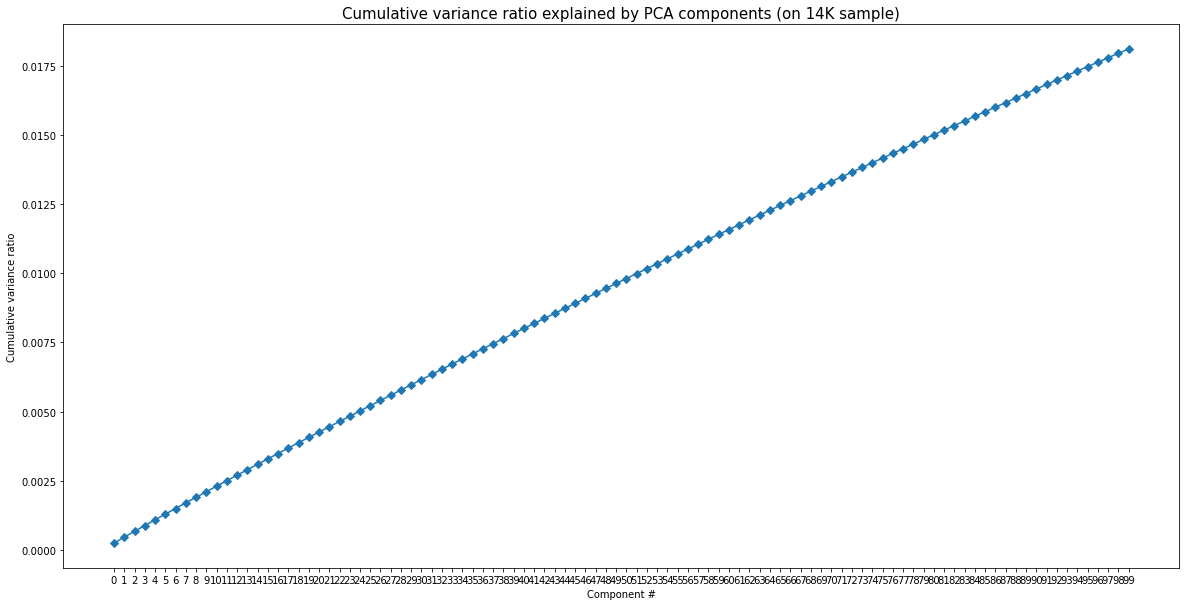

In [25]:
# plot the Cumulative Variance Ratio
plt.subplots(figsize=(20, 10))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='D')
plt.xlabel('Component #')
plt.xticks(np.arange(0,100))
plt.ylabel('Cumulative variance ratio')
plt.title('Cumulative variance ratio explained by PCA components (on 14K sample)', fontsize=15);

Hmm, that doesn't seem to be a very valuable move.

100 components accounts for just under 2% of the variance.

It's not even worth trying to run on this on the full dataset.

## 4.3. t-SNE Dimensionality Reduction

Some further research has suggested t-SNE as a good first step in Dimensionality Reduction. Let's try that out here, again first starting with the sample.

Dask_ML doesn't have an implementation of t-SNE, so let's load the local version of our feature array as a pandas dataframe.

In [ ]:
df_sample = ddf_sample.compute()

In [ ]:
df_sample.info()

In [42]:
# Create a TSNE instance: model
tsne = TSNE(learning_rate=200)

In [47]:
%%time
# Apply fit_transform to samples: tsne_features 
# run on cluster with joblib
with joblib.parallel_backend('dask'):
    tsne_features = tsne.fit_transform(dX_sample)

CPU times: user 15min 33s, sys: 53.4 s, total: 16min 26s
Wall time: 10min 47s


In [50]:
# save the 2 components to df
df_sample['tsne_2d_one'] = tsne_features[:,0]
df_sample['tsne_2d_two'] = tsne_features[:,1]

In [51]:
df_sample.head()

appearance_count  user_tweet_count  timestamp_counts  follower_count  \
6867                 1              8062             481.0          3457.0   
2787                 1             10993            2338.0          1723.0   
6384                 1             14011             341.0           570.0   
2725                 1              9634             176.0           704.0   
2348                 7             17431            2471.0          1222.0   

      following_count  flagged    0    1    2    3  ...  dialect_pred_RIY  \
6867            999.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2787            484.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
6384             26.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2725             11.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2348           2277.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   

      dialect_pred_SAL  dialect_pred_SAN  dialect_pred_SFX  dialect_pred_TRI  \
6867               0.0               0.0               0.0               0.0   
2787               0.0               0.0               0.0               0.0   
6384               0.0               0.0               0.0               0.0   
2725               0.0               0.0               0.0               0.0   
2348               0.0               0.0               0.0               0.0   

      dialect_pred_TUN  sentiment_pred_neutral  sentiment_pred_positive  \
6867               0.0                     0.0                      0.0   
2787               0.0                     0.0                      0.0   
6384               0.0                     1.0                      0.0   
2725               0.0                     1.0                      0.0   
2348               0.0                     0.0                      0.0   

      tsne_2d_one  tsne_2d_two  
6867   -95.684776    -2.225057  
2787   -57.821476   -41.067196  
6384   -47.182724   -62.056129  
2725    30.580181    76.616516  
2348   -31.817627   -46.696384  

[5 rows x 10923 columns]

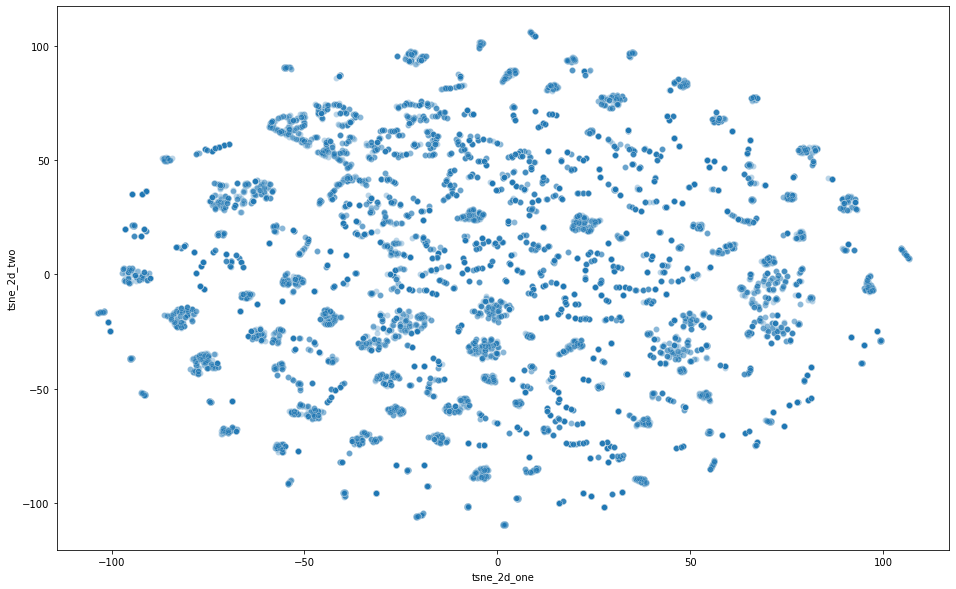

In [56]:
# Scatter plot, coloring by
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    data=df_sample,
    legend="full",
    alpha=0.3
);

Interesting. Definitely looks there are some small clusters here and there.

Let's see if we see anything meaningful if we color by sentiment_neutral and sentiment_positive.

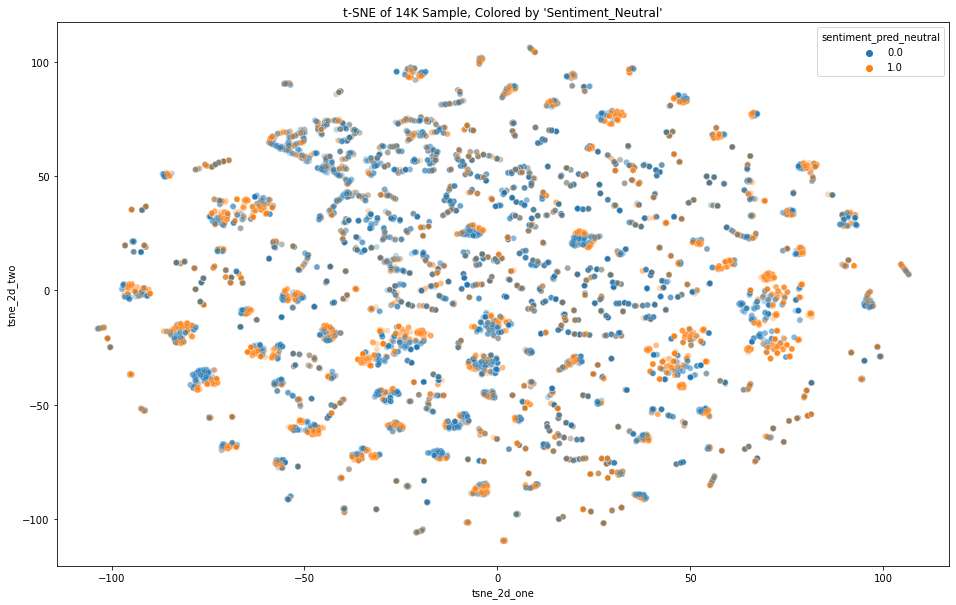

In [60]:
# Scatter plot, coloring by
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="sentiment_pred_neutral",
    data=df_sample,
    legend="full",
    alpha=0.3
)
plt.title("t-SNE of 14K Sample, Colored by 'Sentiment_Neutral'");

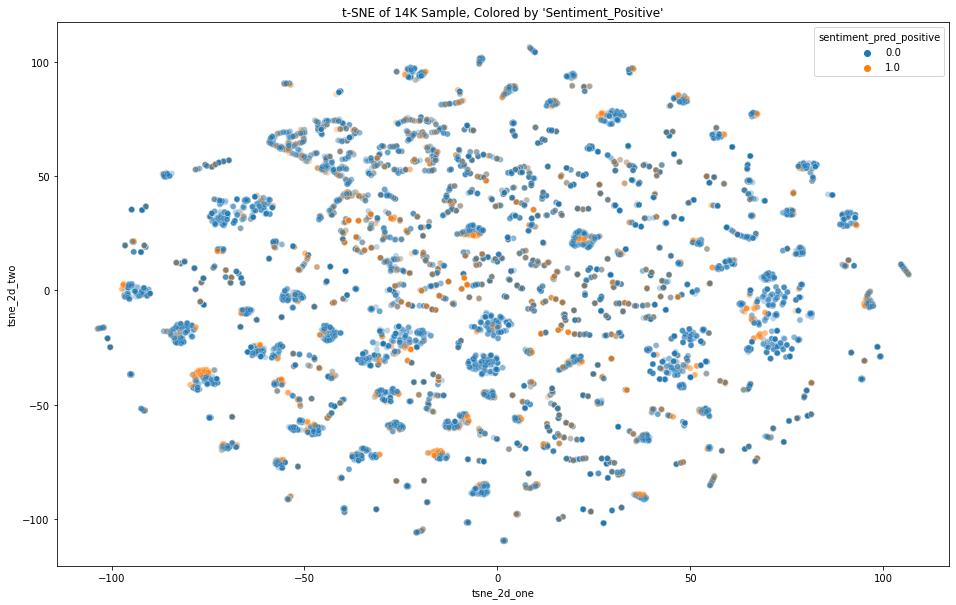

In [59]:
# Scatter plot, coloring by
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="sentiment_pred_positive",
    data=df_sample,
    legend="full",
    alpha=0.3
)
plt.title("t-SNE of 14K Sample, Colored by 'Sentiment_Positive'");

In [76]:
df_sample.columns[-35:]

Index(['10882', '10883', '10884', 'gsdmm_topic_11', 'gsdmm_topic_12',
       'gsdmm_topic_18', 'dialect_pred_ALG', 'dialect_pred_ALX',
       'dialect_pred_AMM', 'dialect_pred_ASW', 'dialect_pred_BAG',
       'dialect_pred_BAS', 'dialect_pred_BEI', 'dialect_pred_BEN',
       'dialect_pred_CAI', 'dialect_pred_DAM', 'dialect_pred_DOH',
       'dialect_pred_FES', 'dialect_pred_JED', 'dialect_pred_JER',
       'dialect_pred_KHA', 'dialect_pred_MOS', 'dialect_pred_MSA',
       'dialect_pred_MUS', 'dialect_pred_RAB', 'dialect_pred_RIY',
       'dialect_pred_SAL', 'dialect_pred_SAN', 'dialect_pred_SFX',
       'dialect_pred_TRI', 'dialect_pred_TUN', 'sentiment_pred_neutral',
       'sentiment_pred_positive', 'tsne_2d_one', 'tsne_2d_two'],
      dtype='object')

Let's try coloring by the predicted topic labels from our GSDMM Model

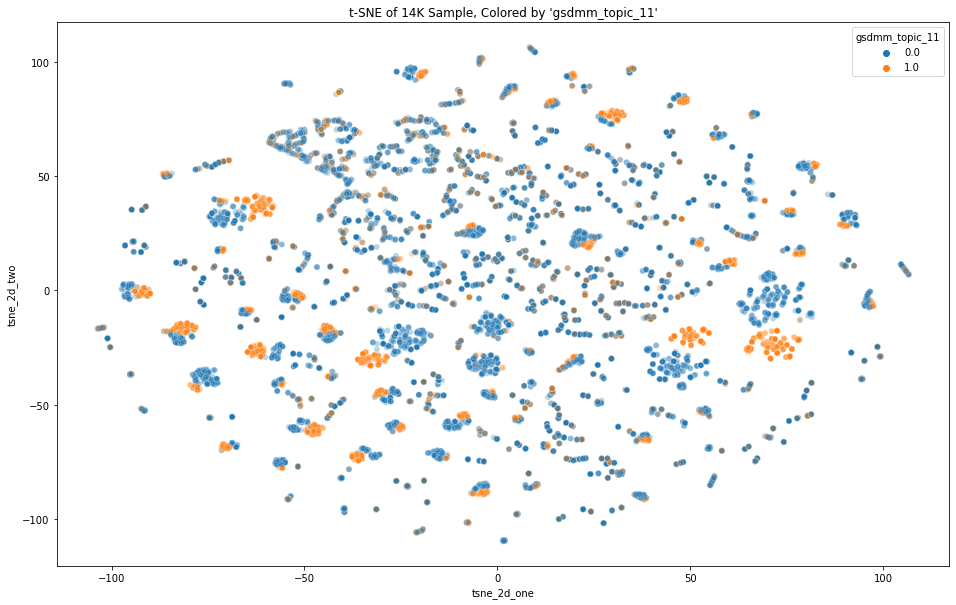

In [78]:
# Scatter plot, coloring by
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="gsdmm_topic_11",
    data=df_sample,
    legend="full",
    alpha=0.3
)
plt.title("t-SNE of 14K Sample, Colored by 'gsdmm_topic_11'");

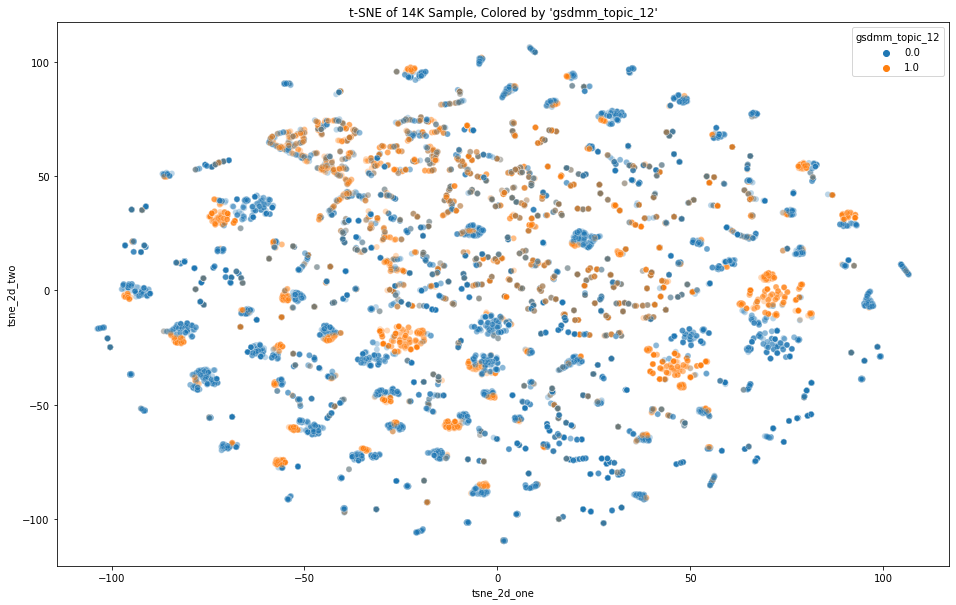

In [80]:
# Scatter plot, coloring by
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="gsdmm_topic_12",
    data=df_sample,
    legend="full",
    alpha=0.3
)
plt.title("t-SNE of 14K Sample, Colored by 'gsdmm_topic_12'");

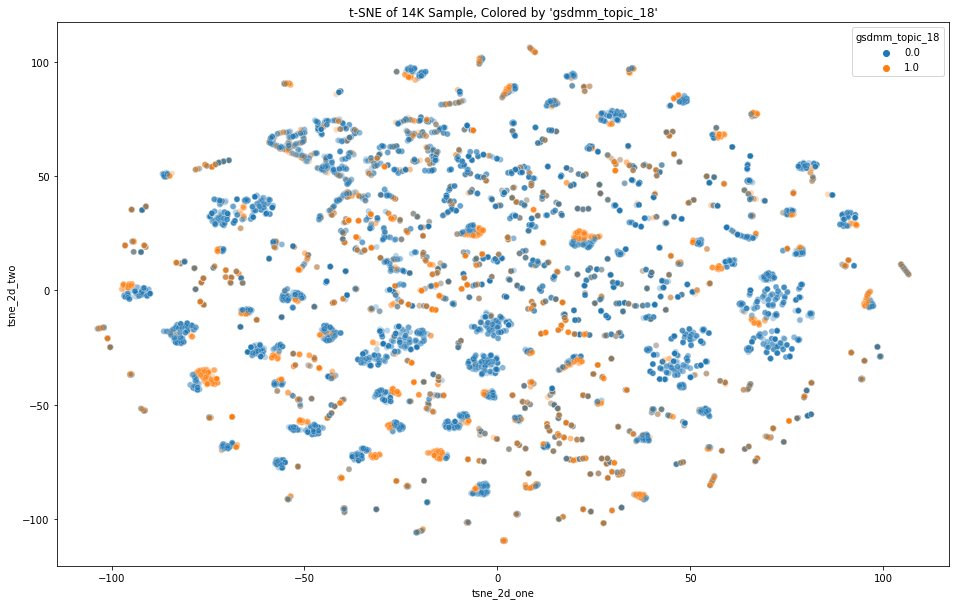

In [82]:
# Scatter plot, coloring by
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="gsdmm_topic_18",
    data=df_sample,
    legend="full",
    alpha=0.3
)
plt.title("t-SNE of 14K Sample, Colored by 'gsdmm_topic_18'");

This seems promising. Some clear clusters based on gsdmm_topic label.

I think it's worth creating a single plot with all the topics colored. But because we one-hot encoded that column we 'll have to do a little juggling to make that work

In [111]:
df_plot = df_sample.copy()

In [112]:
df_plot['topics'] = 0

In [113]:
for index, col_name in enumerate(df_plot[['gsdmm_topic_11', 'gsdmm_topic_12', 'gsdmm_topic_18']].columns):
    df_plot.loc[df_plot[col_name]==1,'topics'] = index + 1

In [114]:
df_plot.head()

appearance_count  user_tweet_count  timestamp_counts  follower_count  \
6867                 1              8062             481.0          3457.0   
2787                 1             10993            2338.0          1723.0   
6384                 1             14011             341.0           570.0   
2725                 1              9634             176.0           704.0   
2348                 7             17431            2471.0          1222.0   

      following_count  flagged    0    1    2    3  ...  dialect_pred_SAL  \
6867            999.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2787            484.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
6384             26.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2725             11.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2348           2277.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   

      dialect_pred_SAN  dialect_pred_SFX  dialect_pred_TRI  dialect_pred_TUN  \
6867               0.0               0.0               0.0               0.0   
2787               0.0               0.0               0.0               0.0   
6384               0.0               0.0               0.0               0.0   
2725               0.0               0.0               0.0               0.0   
2348               0.0               0.0               0.0               0.0   

      sentiment_pred_neutral  sentiment_pred_positive  tsne_2d_one  \
6867                     0.0                      0.0   -95.684776   
2787                     0.0                      0.0   -57.821476   
6384                     1.0                      0.0   -47.182724   
2725                     1.0                      0.0    30.580181   
2348                     0.0                      0.0   -31.817627   

      tsne_2d_two  topics  
6867    -2.225057       2  
2787   -41.067196       2  
6384   -62.056129       1  
2725    76.616516       1  
2348   -46.696384       2  

[5 rows x 10924 columns]

Let's now map the values to our gsdmm topic numbers.

As a reminder:
- 0: gsdmm_topic_4
- 1: gsdmm_topic_11
- 2: gsdmm_topic_12
- 3: gsdmm_topic_18

In [121]:
mapping = {0: 4,
           1: 11,
           2: 12,
           3: 18}

In [122]:
df_plot["topics"].replace(mapping, inplace=True)

In [123]:
df_plot.head()

appearance_count  user_tweet_count  timestamp_counts  follower_count  \
6867                 1              8062             481.0          3457.0   
2787                 1             10993            2338.0          1723.0   
6384                 1             14011             341.0           570.0   
2725                 1              9634             176.0           704.0   
2348                 7             17431            2471.0          1222.0   

      following_count  flagged    0    1    2    3  ...  dialect_pred_SAL  \
6867            999.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2787            484.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
6384             26.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2725             11.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2348           2277.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   

      dialect_pred_SAN  dialect_pred_SFX  dialect_pred_TRI  dialect_pred_TUN  \
6867               0.0               0.0               0.0               0.0   
2787               0.0               0.0               0.0               0.0   
6384               0.0               0.0               0.0               0.0   
2725               0.0               0.0               0.0               0.0   
2348               0.0               0.0               0.0               0.0   

      sentiment_pred_neutral  sentiment_pred_positive  tsne_2d_one  \
6867                     0.0                      0.0   -95.684776   
2787                     0.0                      0.0   -57.821476   
6384                     1.0                      0.0   -47.182724   
2725                     1.0                      0.0    30.580181   
2348                     0.0                      0.0   -31.817627   

      tsne_2d_two  topics  
6867    -2.225057      12  
2787   -41.067196      12  
6384   -62.056129      11  
2725    76.616516      11  
2348   -46.696384      12  

[5 rows x 10924 columns]

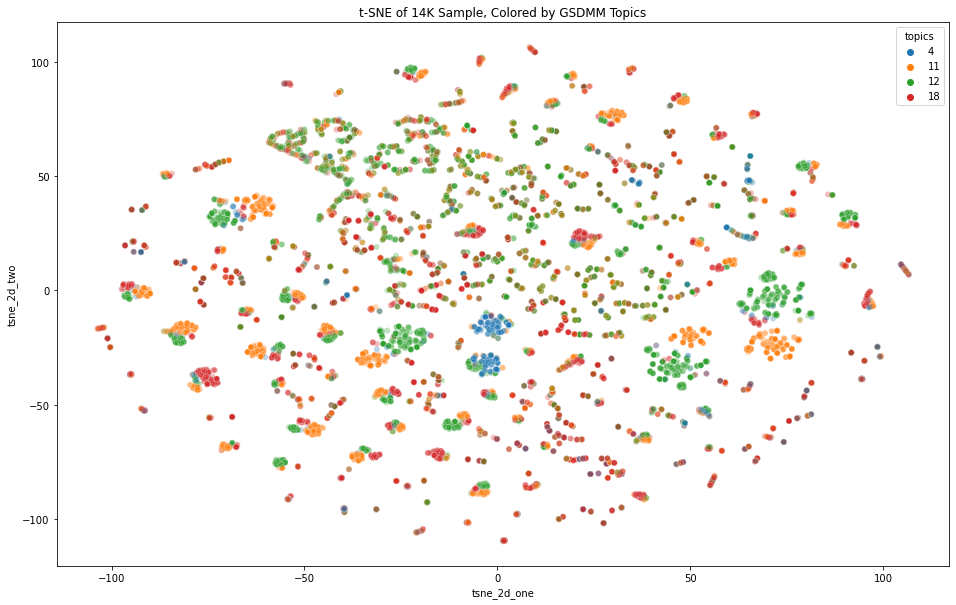

In [124]:
# Scatter plot, coloring by topics
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue='topics',
    palette='tab10',
    data=df_plot,
    legend="full",
    alpha=0.3
)
plt.title("t-SNE of 14K Sample, Colored by GSDMM Topics");

Interesting. Definitely confirms that the GSDMM Topics are a pretty efficient way of clustering this data.

Interesting to see that **Topic 11** and **Topic 12** often appear close together in adjacent (or identical) clusters. To refresh our memory, here are the keywords we noted in each of those topics:

- Cluster 12: Terrorist / Middle East: Qatar, Terrorism, Sudan, Brotherhood, Terrorist, Arab, Country, Party
- Cluster 18: Saudi Politics: Saudi, Mohammed, Emirate, President, Salman, Arab, King, Prince, Egypt
- Cluster 11: Middle East Politics: President, Egypt, Minister ,Saudi, Arab, Parliament, Iran, Sisi, American
- Cluster 4: Syria: Syria, Country, Bombing, Regime, Power, Damascus, City, Dara'a (city), Idlib (city), Asad

Topics 11 and 12 do seem to overlap in content referring to regional Middle East politics.

That said, we are still left with some scattered clouds of datapoints in the top left and around the bottom periphery of the plot.

**Also very important to remember that this is just a 5% sample of the entire dataset.** So we shouldn't draw too many conclusions from this, but it's definitely a useful indicator.

## 4.4. Spectral Clustering

The trouble with running t-SNE is that there is no Dask-ML implementation and so we can't take maximum benefit of the possibilities of distributing processing. Specifically, the data we feed into the t-SNE needs to be stored locally (as opposed to a Dask array that lives in the cluster)...which slows things down considerably.

[This article](https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6) suggests that **Spectral Clustering** is one of the most suitable approaches for high-dimensional data. Since Dask-ML **does** have an implementation of that, we will give that a swing here before deciding what to do next.

From the Sklearn Documentation:
- "SpectralClustering performs a low-dimension embedding of the affinity matrix between samples, followed by clustering, e.g., by KMeans, of the components of the eigenvectors in the low dimensional space."
- The Dask Implementation, by default creates an instance of dask_ml.cluster.KMeans and sets n_clusters to 2. For further control over the hyperparameters of the final label assignment, pass an instance of a KMeans estimator (either scikit-learn or dask-ml).

In [19]:
ddf_sample.dtypes

appearance_count             int64
user_tweet_count             int64
timestamp_counts           float64
follower_count             float64
following_count            float64
                            ...   
dialect_pred_SFX           float64
dialect_pred_TRI           float64
dialect_pred_TUN           float64
sentiment_pred_neutral     float64
sentiment_pred_positive    float64
Length: 10921, dtype: object

In [20]:
# set all datatypes to floar
ddf_sample.appearance_count = ddf_sample.appearance_count.astype('float64')
ddf_sample.user_tweet_count = ddf_sample.user_tweet_count.astype('float64')

In [21]:
# create new dX_sample with right datatypes
dX_sample_new = ddf_sample.sample(frac=0.01,random_state=2).to_dask_array()

In [22]:
dX_sample_new.persist()

dask.array<values, shape=(nan, 10921), dtype=float64, chunksize=(nan, 10921), chunktype=numpy.ndarray>

In [23]:
# scale
dX_sample_new_scaled = scaler.fit_transform(dX_sample_new)

In [24]:
# compute chunk sizes
dX_sample_new_scaled = dX_sample_new_scaled.compute_chunk_sizes()

In [25]:
dX_sample_new_scaled

dask.array<truediv, shape=(150, 10921), dtype=float64, chunksize=(6, 10921), chunktype=numpy.ndarray>

In [26]:
sc = SpectralClustering(n_clusters=8,
                        gamma=1.0,
                        affinity='rbf',
                        n_jobs=-1,
                        n_components=100,
                        persist_embedding=True
)

In [27]:
%%time
# fit SpectralClustering to sample data
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sc_labels = sc.fit_predict(dX_sample_new_scaled)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Having trouble getting this to run on an even a small subset of the data.

The error message states that the input contains NaN, infinity or a value too large for dtype('float64'). But I've triple-checked and my sample definitely doesn't contain any of those. I've also looked through the dask-ml source code and this is the check where it seems to be failing:
```
  bad = (da.isnull(X).any(), da.isinf(X).any())
        if any(*compute(bad)):
            msg = (
                "Input contains NaN, infinity or a value too large for "
                "dtype('float64')."
            )
            raise ValueError(msg)
```
However when I run da.isnull(X).any() and da.isinf(X).any() on my original dask array, they both return FALSE.

Trying to reproduce the error with just a Dask Array of random floats between 0 and 1 shows that it has to do something with the size of the array; specifically the number of columns. The model is fit when the Dask Array has 1000 columns but not with 10000 columns. 

- 1,000,000 * 1,000 works
- 1,000 * 10,000 doesn't

I'm waiting to hear back from the Dask maintainers about why this happens exactly and how to fix it. But in the meantime I have to proceed as this project's deadline is coming up and we have more work to.


# Conclusions (for now)
So for now we have to conclude the following:
- We are not able to effectively cluster the subset of Political Tweets at the moment due to technical constraints
- The t-SNE revealed, however, that the GSDMM Topics seem to be a good starting point for clustering tweets together
- Perhaps in combination with sentiment and dialect (and user characteristics)?

Let's try running the Spectral Clustering on the Political Tweets **without the 10,000+ tf-idf vectors**.

In [28]:
ddf_sample.head()

appearance_count  user_tweet_count  timestamp_counts  follower_count  \
6867               1.0            8062.0             481.0          3457.0   
2787               1.0           10993.0            2338.0          1723.0   
6384               1.0           14011.0             341.0           570.0   
2725               1.0            9634.0             176.0           704.0   
2348               7.0           17431.0            2471.0          1222.0   

      following_count  flagged    0    1    2    3  ...  dialect_pred_MUS  \
6867            999.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2787            484.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
6384             26.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2725             11.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   
2348           2277.0      1.0  0.0  0.0  0.0  0.0  ...               0.0   

      dialect_pred_RAB  dialect_pred_RIY  dialect_pred_SAL  dialect_pred_SAN  \
6867               0.0               0.0               0.0               0.0   
2787               0.0               0.0               0.0               0.0   
6384               0.0               0.0               0.0               0.0   
2725               0.0               0.0               0.0               0.0   
2348               0.0               0.0               0.0               0.0   

      dialect_pred_SFX  dialect_pred_TRI  dialect_pred_TUN  \
6867               0.0               0.0               0.0   
2787               0.0               0.0               0.0   
6384               0.0               0.0               0.0   
2725               0.0               0.0               0.0   
2348               0.0               0.0               0.0   

      sentiment_pred_neutral  sentiment_pred_positive  
6867                     0.0                      0.0  
2787                     0.0                      0.0  
6384                     1.0                      0.0  
2725                     1.0                      0.0  
2348                     0.0                      0.0  

[5 rows x 10921 columns]

Let's subset the columns that are **not the text/tf-idf vectors**.

In [57]:
ddf_sample_notext = ddf_sample[['appearance_count',
                                'user_tweet_count',
                                'timestamp_counts',
                                'follower_count',
                                'following_count',
                                'gsdmm_topic_11', 
                                'gsdmm_topic_12', 
                                'gsdmm_topic_18',
                                'dialect_pred_ALG', 
                                'dialect_pred_ALX', 
                                'dialect_pred_AMM',
                                'dialect_pred_ASW', 
                                'dialect_pred_BAG', 
                                'dialect_pred_BAS',
                                'dialect_pred_BEI', 
                                'dialect_pred_BEN', 
                                'dialect_pred_CAI',
                                'dialect_pred_DAM', 
                                'dialect_pred_DOH', 
                                'dialect_pred_FES',
                                'dialect_pred_JED', 
                                'dialect_pred_JER', 
                                'dialect_pred_KHA',
                                'dialect_pred_MOS', 
                                'dialect_pred_MSA', 
                                'dialect_pred_MUS',
                                'dialect_pred_RAB', 
                                'dialect_pred_RIY', 
                                'dialect_pred_SAL',
                                'dialect_pred_SAN', 
                                'dialect_pred_SFX', 
                                'dialect_pred_TRI',
                                'dialect_pred_TUN', 
                                'sentiment_pred_neutral',
                                'sentiment_pred_positive']]

In [58]:
ddf_sample_notext.columns, len(ddf_sample_notext.columns)

(Index(['appearance_count', 'user_tweet_count', 'timestamp_counts',
        'follower_count', 'following_count', 'gsdmm_topic_11', 'gsdmm_topic_12',
        'gsdmm_topic_18', 'dialect_pred_ALG', 'dialect_pred_ALX',
        'dialect_pred_AMM', 'dialect_pred_ASW', 'dialect_pred_BAG',
        'dialect_pred_BAS', 'dialect_pred_BEI', 'dialect_pred_BEN',
        'dialect_pred_CAI', 'dialect_pred_DAM', 'dialect_pred_DOH',
        'dialect_pred_FES', 'dialect_pred_JED', 'dialect_pred_JER',
        'dialect_pred_KHA', 'dialect_pred_MOS', 'dialect_pred_MSA',
        'dialect_pred_MUS', 'dialect_pred_RAB', 'dialect_pred_RIY',
        'dialect_pred_SAL', 'dialect_pred_SAN', 'dialect_pred_SFX',
        'dialect_pred_TRI', 'dialect_pred_TUN', 'sentiment_pred_neutral',
        'sentiment_pred_positive'],
       dtype='object'),
 35)

Great, that's just 35 features.

In [60]:
# convert to dask array
dX_sample_notext = ddf_sample_notext.to_dask_array()

In [61]:
# scale
dX_sample_notext_scaled = scaler.fit_transform(dX_sample_notext)

In [62]:
# compute chunk sizes
dX_sample_notext_scaled = dX_sample_notext_scaled.compute_chunk_sizes()

In [63]:
dX_sample_notext_scaled.persist()

dask.array<truediv, shape=(14224, 35), dtype=float64, chunksize=(569, 35), chunktype=numpy.ndarray>

In [66]:
%%time
# fit SpectralClustering to sample data
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sc_labels = sc.fit_predict(dX_sample_notext_scaled)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Grrr... That same error again, even though the Array is much smaller. This is getting aggrevating.

I'll need more input from the Dask maintainers to figure this one out.

But I think it does pose an interesting question that we can explore in the next **classification** notebook, namely:

> To what extent can we predict a political tweet's sub-topic based on all the features we have **other than** the text-based features (i.e. Tf-Idf vectors in this case).

I'm curious to see what the predictive power of, for example, dialect and sentiment - but also the user characteristics, in predicting the sub-topic of each political tweet.